In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [36]:
conn = sqlite3.connect(r'C:\Users\kenta\OneDrive\Desktop\Platinum Binar\database.db', check_same_thread=False)
query = 'SELECT * FROM new_data'
data = pd.read_sql_query (query, conn)
data.head()

,Tweet,Label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus men...,positive
4,aduh mahasiswa sombong kasih kartu kuning bela...,negative


In [37]:
data['Label'].value_counts()


Label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

In [38]:
# Oversampling neutral label to be equal with negative label

data_pos = data[data['Label']=='positive']
data_neu = data[data['Label']=='neutral']
data_neg = data[data['Label']=='negative']

df_neu = data_neu.sample(data_neg.shape[0], replace = True)

data = pd.concat([data_pos, df_neu, data_neg])

# Group data tweet

pos_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
neg_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neu_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

pos_label = data.loc[data['Label']=='positive'].Label.tolist()
neg_label = data.loc[data['Label']=='negative'].Label.tolist()
neu_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [39]:
# Final sentiment data check

total_tweets_assemble = pos_tweet + neg_tweet + neu_tweet
labels = pos_label + neu_label + neg_label

print("Positive: %s, Neutral: %s, Negative: %s" % (len(pos_tweet), len(neu_tweet), len(neg_tweet)))
print("Total data: %s" % len(total_tweets_assemble))
print("Total labels: %s" % len(labels))

Positive: 6383, Neutral: 3412, Negative: 3412
Total data: 13207
Total labels: 13207


Feature Extraction

Pemanfaatan tokenizer untuk melakukan ekstraksi data agar mudah diproses dalam modeling data.

In [40]:
max_features_tokenize = 100000
data_tokenizer = Tokenizer(num_words=max_features_tokenize, split=' ', lower=True)
data_tokenizer.fit_on_texts(total_tweets_assemble)

#Penyimpanan data TokenizerFile kedalam pickle
with open('TokenizerFile.pickle', 'wb') as file:
    pickle.dump(data_tokenizer, file , protocol=pickle.HIGHEST_PROTOCOL)
    print('File "TokenizerFile.pickle" telah tercetak!')

File "TokenizerFile.pickle" telah tercetak!


In [41]:
#Feature Extraction of X data
X = data_tokenizer.texts_to_sequences(total_tweets_assemble)
maxlen = max(len(x) for x in X)
X = pad_sequences(X)

#Penyimpanan data x_pad_sequences kedalam pickle
with open('x_pad_sequences.pickle', 'wb') as file:
    pickle.dump(X, file , protocol=pickle.HIGHEST_PROTOCOL)
    print('File "x_pad_sequences.pickle" telah tercetak!')


#Feature Extraction of Y data
y = pd.get_dummies(labels)
y = y.values

#Penyimpanan data x_target kedalam library pickle
with open('x_target.pickle', 'wb') as file:
    pickle.dump(y, file, protocol=pickle.HIGHEST_PROTOCOL)

File "x_pad_sequences.pickle" telah tercetak!


In [42]:
X.shape

(13207, 55)

Train-Test Split Data

In [43]:
#Split train-test dataset
#Loading Dataset
x_file = open('x_pad_sequences.pickle', 'rb')
x = pickle.load(x_file)
x_file.close()

y_file = open('x_target.pickle', 'rb')
y = pickle.load(y_file)
y_file.close()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=42)

In [44]:
#Pelatihan model menggunakan Train-Test Split
model = Sequential()
model.add(Embedding(max_features_tokenize, output_dim = 100, input_length = x.shape[1] ))
model.add(LSTM(units= 64, dropout=0.2))
model.add(Dense(units=y.shape[1], activation= 'softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam_optim = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam_optim, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history1 = model.fit(x_train, y_train, epochs=20, batch_size=32, 
                        validation_data=(x_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 55, 100)           10000000  
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
289/289 [==============================] - 29s 94ms/step - loss: 0.9274 - accuracy: 0.5822 - val_loss: 0.7507 - val_accuracy: 0.6667
Epoch 2/20
289/289 [==============================] - 27s 94ms/step - loss: 0.6876 - accuracy: 0.6833 - val_loss: 0.6370 - val_

In [45]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features_tokenize, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3, activation='softmax'))
    adam = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def train_model(model, data_train, target_train, data_test, target_test):
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) #Diganti dan tidak usah dipakai pada model kedua
    history = model.fit(data_train, target_train, epochs=8, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1)
    return model, history

# Inisialisasi KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []


embed_dim = 100
units = 64

# Iterasi melalui lipatan (folds) KFold
for iteration, data in enumerate(kf.split(X), start=1):
    data_train, target_train = X[data[0]], y[data[0]]
    data_test, target_test = X[data[1]], y[data[1]]

    model = create_model()
    trained_model, history = train_model(model, data_train, target_train, data_test, target_test)

    # Prediksi
    predictions = trained_model.predict(x_test)
    y_pred = predictions

    # Menghitung akurasi
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    # Menampilkan hasil
    print(f"Iterasi ke-{iteration}")
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# Menghitung rata-rata akurasi
average_accuracy = np.mean(accuracies)

print("\n\n\n")
print("Rata-rata Akurasi:", round(average_accuracy, 4))

Epoch 1/8
331/331 [==============================] - 30s 86ms/step - loss: 0.9198 - accuracy: 0.5782 - val_loss: 0.7603 - val_accuracy: 0.6609
Epoch 2/8
331/331 [==============================] - 28s 85ms/step - loss: 0.6876 - accuracy: 0.6804 - val_loss: 0.6418 - val_accuracy: 0.6862
Epoch 3/8
331/331 [==============================] - 29s 87ms/step - loss: 0.5924 - accuracy: 0.7345 - val_loss: 0.5658 - val_accuracy: 0.7737
Epoch 4/8
331/331 [==============================] - 29s 87ms/step - loss: 0.5050 - accuracy: 0.8087 - val_loss: 0.4968 - val_accuracy: 0.8225
Epoch 5/8
331/331 [==============================] - 28s 85ms/step - loss: 0.4293 - accuracy: 0.8446 - val_loss: 0.4466 - val_accuracy: 0.8425
Epoch 6/8
331/331 [==============================] - 29s 87ms/step - loss: 0.3633 - accuracy: 0.8699 - val_loss: 0.4196 - val_accuracy: 0.8478
Epoch 7/8
331/331 [==============================] - 29s 87ms/step - loss: 0.3115 - accuracy: 0.8882 - val_loss: 0.3956 - val_accuracy: 0.8562

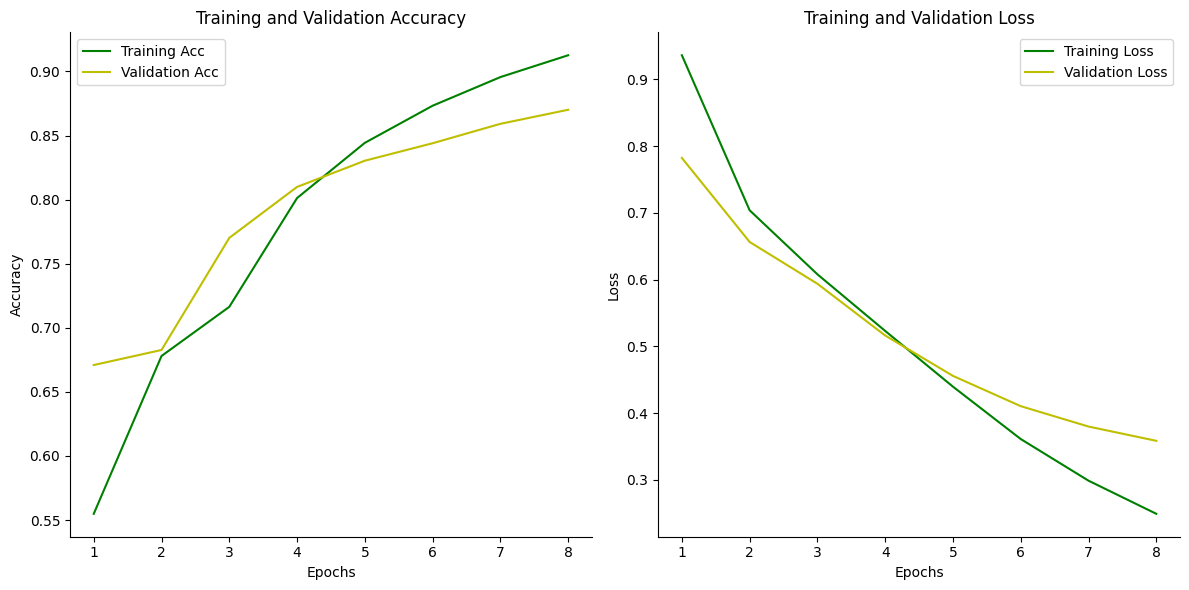

In [46]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Training Acc')
    plt.plot(epochs, val_acc, 'y', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    sns.despine()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    sns.despine()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_history untuk memvisualisasikan hasil
plot_history(history)

In [47]:
#Save model
trained_model.save('main_model_new.h5')
print('Model has created')


C:\Users\kenta\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created


In [99]:
input_text = """Makanannya enak"""
def cleansing(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus URL dan tautan
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    # Menghapus karakter yang tidak diinginkan, termasuk angka
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Menghapus kata 'user'
    text = text.replace('user', '')
    # Menghapus spasi berlebih
    text = re.sub(' +', ' ', text)
    # Menghapus karakter \n (newline)
    text = text.replace('\n', ' ')
    # menghapus kata 'url' 
    text = re.sub('url',' ', text)
    return text

sentiment = ['negative', 'neutral','positive']

text = [cleansing(input_text)]
predicted = data_tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model1 =  load_model('main_model_new.h5')
prediction = model1.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]
print("Tokenized Sequence: %s" % predicted)


print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])
print("Polarity: %s" % polarity)


OSError: No file or directory found at main_model_new.h5

In [57]:
input_text = """warung dimiliki pengusaha pabrik puluhan terkenal membuat putih bandung berkualitas dipadu keahlian memasak dipadu kretivitas warung menyajikan menu utama berbahan ditambah menu ayam selera indonesia harga terjangkau jangan melewati bletoka tidak kalah asli tegal"""
def cleansing(text):
    text = text.lower()
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = text.replace('user', '')
    text = re.sub(' +', ' ', text)
    text = text.replace('\n', ' ')
    return text

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = data_tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model1 =  load_model('main_model_new.h5')
prediction = model1.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 333ms/step
Text: warung dimiliki pengusaha pabrik puluhan terkenal membuat putih bandung berkualitas dipadu keahlian memasak dipadu kretivitas warung menyajikan menu utama berbahan ditambah menu ayam selera indonesia harga terjangkau jangan melewati bletoka tidak kalah asli tegal
Sentiment: positive


In [98]:
input_text = """dia baik sekali ya dan rajin"""
def cleansing(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus URL dan tautan
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    # Menghapus karakter yang tidak diinginkan, termasuk angka
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Menghapus kata 'user'
    text = text.replace('user', '')
    # Menghapus spasi berlebih
    text = re.sub(' +', ' ', text)
    # Menghapus karakter \n (newline)
    text = text.replace('\n', ' ')
    # menghapus kata 'url' 
    text = re.sub('url',' ', text)
    return text

sentiment = ['negative', 'neutral','positive']

text = [cleansing(input_text)]
predicted = data_tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model1 =  load_model('main_model_new.h5')
prediction = model1.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]
print("Tokenized Sequence: %s" % predicted)


print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])
print("Polarity: %s" % polarity)


1/1 [==============================] - 0s 323ms/step
Tokenized Sequence: [[4354]]
Text: dia baik sekali ya dan rajin
Sentiment: negative
Polarity: 0
